## Mask-Based Diffusion for Music Generation: Interactive Demo

This notebook demonstrates how to generate music from everyday sounds using a mask-based diffusion pipeline. You'll learn how to load audio, convert it to a spectrogram, apply creative transformations, and generate new music with custom prompts.
---

# Text-guided image-to-image generation

## 1. Install and Import Required Libraries
We use HuggingFace Diffusers, PyTorch, Torchaudio, and other libraries for audio and image processing. If running in Colab, install missing packages first.

The [StableDiffusionImg2ImgPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/img2img#diffusers.StableDiffusionImg2ImgPipeline) lets you pass a text prompt and an initial image to condition the generation of new images.

Before you begin, make sure you have all the necessary libraries installed:

In [1]:
#@title Imports
!pip install diffusers huggingface-hub accelerate
!pip install transformers ftfy torch torchaudio ipython typing


# Importing necessary classes and functions
import inspect
from typing import Callable, List, Optional, Union
import librosa
import numpy as np
import PIL
import torch
import torchvision.transforms
from packaging import version
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

from diffusers.configuration_utils import FrozenDict
from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers.schedulers import KarrasDiffusionSchedulers
from diffusers.utils import (
    PIL_INTERPOLATION,
    deprecate,
    is_accelerate_available,
    is_accelerate_version,
    logging,
    replace_example_docstring,
)
from diffusers.pipelines.pipeline_utils import DiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker

# Importing StableDiffusionImg2ImgPipeline
from diffusers import StableDiffusionImg2ImgPipeline

import locale
import numpy as np
from PIL import Image, ImageEnhance, ImageChops
import torch
import requests
from io import BytesIO
import ipywidgets as widgets
from IPython.display import display
from typing import *
import torchaudio
from IPython.display import Audio
from torchvision import transforms
import locale
locale.getpreferredencoding = lambda: "UTF-8"




## 2. Connect to Google Drive (Colab Only)
If you're running this notebook in Google Colab, mount your Google Drive to access audio files and save outputs.

In [2]:
#@title Connect to drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


## 3. Set Mel-Spectrogram Parameters
These variables define how audio is converted to a spectrogram image. You can adjust sample rate, duration, and FFT settings for your use case.

In [4]:
#@title Mel-Spectrogram Variables
image_width = 512
sample_rate = 44100  # [Hz]
clip_duration_ms = 5000  # [ms]

bins_per_image = 512
n_mels = 512

# FFT parameters
window_duration_ms = 100  # [ms]
padded_duration_ms = 400  # [ms]
step_size_ms = 10  # [ms]

# Derived parameters
num_samples = int(image_width / float(bins_per_image) * clip_duration_ms) * sample_rate
n_fft = int(padded_duration_ms / 1000.0 * sample_rate)
hop_length = int(step_size_ms / 1000.0 * sample_rate)
win_length = int(window_duration_ms / 1000.0 * sample_rate)

## 4. Utility Functions for Audio & Image Processing
The following functions help convert between audio, spectrograms, and images, and apply transformations. You can reuse or modify them for your own experiments.

In [5]:
#@title Function Definitions
def randn_tensor(
    shape: Union[Tuple, List],
    generator: Optional[Union[List["torch.Generator"], "torch.Generator"]] = None,
    device: Optional["torch.device"] = None,
    dtype: Optional["torch.dtype"] = None,
    layout: Optional["torch.layout"] = None,
):
    """A helper function to create random tensors on the desired `device` with the desired `dtype`. When
    passing a list of generators, you can seed each batch size individually. If CPU generators are passed, the tensor
    is always created on the CPU.
    """
    # device on which tensor is created defaults to device
    rand_device = device
    batch_size = shape[0]

    layout = layout or torch.strided
    device = device or torch.device("cpu")

    if generator is not None:
        gen_device_type = generator.device.type if not isinstance(generator, list) else generator[0].device.type
        if gen_device_type != device.type and gen_device_type == "cpu":
            rand_device = "cpu"
            if device != "mps":
                logger.info(
                    f"The passed generator was created on 'cpu' even though a tensor on {device} was expected."
                    f" Tensors will be created on 'cpu' and then moved to {device}. Note that one can probably"
                    f" slighly speed up this function by passing a generator that was created on the {device} device."
                )
        elif gen_device_type != device.type and gen_device_type == "cuda":
            raise ValueError(f"Cannot generate a {device} tensor from a generator of type {gen_device_type}.")

    # make sure generator list of length 1 is treated like a non-list
    if isinstance(generator, list) and len(generator) == 1:
        generator = generator[0]

    if isinstance(generator, list):
        shape = (1,) + shape[1:]
        latents = [
            torch.randn(shape, generator=generator[i], device=rand_device, dtype=dtype, layout=layout)
            for i in range(batch_size)
        ]
        latents = torch.cat(latents, dim=0).to(device)
    else:
        latents = torch.randn(shape, generator=generator, device=rand_device, dtype=dtype, layout=layout).to(device)

    return latents

def preprocess(image):
    if isinstance(image, torch.Tensor):
        return image
    elif isinstance(image, PIL.Image.Image):
        image = [image]

    if isinstance(image[0], PIL.Image.Image):
        w, h = image[0].size
        w, h = (dim - dim % 8 for dim in (w, h))  # resize to integer multiple of 8

        image = [np.array(i.resize((w, h), resample=PIL_INTERPOLATION["lanczos"]))[None, :] for i in image]
        image = np.concatenate(image, axis=0)
        image = np.array(image).astype(np.float32) / 255.0
        image = image.transpose(0, 3, 1, 2)
        image = 2.0 * image - 1.0
        image = torch.from_numpy(image)
    elif isinstance(image[0], torch.Tensor):
        image = torch.cat(image, dim=0)
    return image

def preprocess_map(map):
    map = map.convert("L")
    map = transforms.CenterCrop((map.size[1] // 64 * 64, map.size[0] // 64 * 64))(map)
    # convert to tensor
    map = transforms.ToTensor()(map)
    map = map.to(device)
    return map

def preprocess_image(image):
    image = image.convert("RGB")
    image = transforms.CenterCrop((image.size[1] // 64 * 64, image.size[0] // 64 * 64))(image)
    image = transforms.ToTensor()(image)
    image = image * 2 - 1
    image = image.unsqueeze(0).to(device)
    return image

def spectrogram_from_image(
    image: Image.Image, max_volume: float = 50, power_for_image: float = 0.25
) -> np.ndarray:

    data = np.array(image).astype(np.float32)
    data = data[::-1, :, 0]
    data = 255 - data
    data = data * max_volume / 255
    data = np.power(data, 1 / power_for_image)

    return data

def waveform_from_spectrogram(
    Sxx: np.ndarray,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    num_samples=num_samples,
    sample_rate=sample_rate,
    mel_scale: bool = True,
    n_mels: int = 512,
    max_mel_iters: int = 200,
    num_griffin_lim_iters: int = 32,
    device: str = "cuda",
) -> np.ndarray:
    Sxx_torch = torch.from_numpy(Sxx).to(device)

    if mel_scale:
        mel_inv_scaler = torchaudio.transforms.InverseMelScale(
            n_mels=n_mels,
            sample_rate=sample_rate,
            f_min=0,
            f_max=10000,
            n_stft=n_fft // 2 + 1,
            norm=None,
            mel_scale="htk"
        ).to(device)
        Sxx_torch = mel_inv_scaler(Sxx_torch)

    griffin_lim = torchaudio.transforms.GriffinLim(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        power=1.0,
        n_iter=num_griffin_lim_iters,
    ).to(device)

    waveform = griffin_lim(Sxx_torch).cpu().numpy()
    return waveform

def spectrogram_from_waveform(
    waveform: np.ndarray,
    sample_rate=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    mel_scale: bool = True,
    n_mels: int = 512,
) -> np.ndarray:
    spectrogram_func = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        power=None,
        hop_length=hop_length,
        win_length=win_length,
    )

    waveform_tensor = torch.from_numpy(waveform.astype(np.float32)).reshape(1, -1)
    Sxx_complex = spectrogram_func(waveform_tensor).numpy()[0]
    Sxx_mag = np.abs(Sxx_complex)

    if mel_scale:
        mel_scaler = torchaudio.transforms.MelScale(
            n_mels=n_mels,
            sample_rate=sample_rate,
            f_min=0,
            f_max=10000,
            n_stft=n_fft // 2 + 1,
            norm=None,
            mel_scale="htk",
        )
        Sxx_mag = mel_scaler(torch.from_numpy(Sxx_mag)).numpy()

    return Sxx_mag

def image_from_spectrogram(spectrogram: np.ndarray, max_volume: float = 50, power_for_image: float = 0.25) -> Image.Image:
    data = np.power(spectrogram, power_for_image)
    data = data * 255 / max_volume
    data = 255 - data
    image = Image.fromarray(data.astype(np.uint8))
    image = image.transpose(Image.FLIP_TOP_BOTTOM)
    image = image.convert("RGB")
    return image

In [6]:
logger = logging.get_logger(__name__)  # pylint: disable=invalid-name

EXAMPLE_DOC_STRING = """
    Examples:
        ```py
        >>> import requests
        >>> import torch
        >>> from PIL import Image
        >>> from io import BytesIO

        >>> from diffusers import StableDiffusionImg2ImgPipeline

        >>> device = "cuda"
        >>> model_id_or_path = "runwayml/stable-diffusion-v1-5"
        >>> pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
        >>> pipe = pipe.to(device)

        >>> url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

        >>> response = requests.get(url)
        >>> init_image = Image.open(BytesIO(response.content)).convert("RGB")
        >>> init_image = init_image.resize((768, 512))

        >>> prompt = "A fantasy landscape, trending on artstation"

        >>> images = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images
        >>> images[0].save("fantasy_landscape.png")
        ```
"""



## 5. Mask Creator Class for Custom Diffusion
This class extends the Stable Diffusion pipeline to support mask-based conditioning. You can adjust mask parameters to control creativity and style in the generated music.

In [7]:
#@title Mask Creator Class
class MaskStableDiffusionImg2ImgPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: KarrasDiffusionSchedulers,
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPFeatureExtractor,
        requires_safety_checker: bool = True,
    ):
        super().__init__()

        if hasattr(scheduler.config, "steps_offset") and scheduler.config.steps_offset != 1:
            deprecation_message = (
                f"The configuration file of this scheduler: {scheduler} is outdated. `steps_offset`"
                f" should be set to 1 instead of {scheduler.config.steps_offset}. Please make sure "
                "to update the config accordingly as leaving `steps_offset` might led to incorrect results"
                " in future versions. If you have downloaded this checkpoint from the Hugging Face Hub,"
                " it would be very nice if you could open a Pull request for the `scheduler/scheduler_config.json`"
                " file"
            )
            deprecate("steps_offset!=1", "1.0.0", deprecation_message, standard_warn=False)
            new_config = dict(scheduler.config)
            new_config["steps_offset"] = 1
            scheduler._internal_dict = FrozenDict(new_config)



        if hasattr(scheduler.config, "clip_sample") and scheduler.config.clip_sample is True:
            deprecation_message = (
                f"The configuration file of this scheduler: {scheduler} has not set the configuration `clip_sample`."
                " `clip_sample` should be set to False in the configuration file. Please make sure to update the"
                " config accordingly as not setting `clip_sample` in the config might lead to incorrect results in"
                " future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very"
                " nice if you could open a Pull request for the `scheduler/scheduler_config.json` file"
            )
            deprecate("clip_sample not set", "1.0.0", deprecation_message, standard_warn=False)
            new_config = dict(scheduler.config)
            new_config["clip_sample"] = False
            scheduler._internal_dict = FrozenDict(new_config)

        if safety_checker is None and requires_safety_checker:
            logger.warning(
                f"You have disabled the safety checker for {self.__class__} by passing `safety_checker=None`. Ensure"
                " that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered"
                " results in services or applications open to the public. Both the diffusers team and Hugging Face"
                " strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling"
                " it only for use-cases that involve analyzing network behavior or auditing its results. For more"
                " information, please have a look at https://github.com/huggingface/diffusers/pull/254 ."
            )

        if safety_checker is not None and feature_extractor is None:
            raise ValueError(
                "Make sure to define a feature extractor when loading {self.__class__} if you want to use the safety"
                " checker. If you do not want to use the safety checker, you can pass `'safety_checker=None'` instead."
            )

        is_unet_version_less_0_9_0 = hasattr(unet.config, "_diffusers_version") and version.parse(
            version.parse(unet.config._diffusers_version).base_version
        ) < version.parse("0.9.0.dev0")
        is_unet_sample_size_less_64 = hasattr(unet.config, "sample_size") and unet.config.sample_size < 64
        if is_unet_version_less_0_9_0 and is_unet_sample_size_less_64:
            deprecation_message = (
                "The configuration file of the unet has set the default `sample_size` to smaller than"
                " 64 which seems highly unlikely. If your checkpoint is a fine-tuned version of any of the"
                " following: \n- CompVis/stable-diffusion-v1-4 \n- CompVis/stable-diffusion-v1-3 \n-"
                " CompVis/stable-diffusion-v1-2 \n- CompVis/stable-diffusion-v1-1 \n- runwayml/stable-diffusion-v1-5"
                " \n- runwayml/stable-diffusion-inpainting \n you should change 'sample_size' to 64 in the"
                " configuration file. Please make sure to update the config accordingly as leaving `sample_size=32`"
                " in the config might lead to incorrect results in future versions. If you have downloaded this"
                " checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for"
                " the `unet/config.json` file"
            )
            deprecate("sample_size<64", "1.0.0", deprecation_message, standard_warn=False)
            new_config = dict(unet.config)
            new_config["sample_size"] = 64
            unet._internal_dict = FrozenDict(new_config)

        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )
        self.vae_scale_factor = 2 ** (len(self.vae.config.block_out_channels) - 1)
        self.register_to_config(requires_safety_checker=requires_safety_checker)

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.enable_sequential_cpu_offload
    def enable_sequential_cpu_offload(self, gpu_id=0):
        r"""
        Offloads all models to CPU using accelerate, significantly reducing memory usage. When called, unet,
        text_encoder, vae and safety checker have their state dicts saved to CPU and then are moved to a
        `torch.device('meta') and loaded to GPU only when their specific submodule has its `forward` method called.
        Note that offloading happens on a submodule basis. Memory savings are higher than with
        `enable_model_cpu_offload`, but performance is lower.
        """
        if is_accelerate_available() and is_accelerate_version(">=", "0.14.0"):
            from accelerate import cpu_offload
        else:
            raise ImportError("`enable_sequential_cpu_offload` requires `accelerate v0.14.0` or higher")

        device = torch.device(f"cuda:{gpu_id}")

        if self.device.type != "cpu":
            self.to("cpu", silence_dtype_warnings=True)
            torch.cuda.empty_cache()  # otherwise we don't see the memory savings (but they probably exist)

        for cpu_offloaded_model in [self.unet, self.text_encoder, self.vae]:
            cpu_offload(cpu_offloaded_model, device)

        if self.safety_checker is not None:
            cpu_offload(self.safety_checker, execution_device=device, offload_buffers=True)

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.enable_model_cpu_offload
    def enable_model_cpu_offload(self, gpu_id=0):
        r"""
        Offloads all models to CPU using accelerate, reducing memory usage with a low impact on performance. Compared
        to `enable_sequential_cpu_offload`, this method moves one whole model at a time to the GPU when its `forward`
        method is called, and the model remains in GPU until the next model runs. Memory savings are lower than with
        `enable_sequential_cpu_offload`, but performance is much better due to the iterative execution of the `unet`.
        """
        if is_accelerate_available() and is_accelerate_version(">=", "0.17.0.dev0"):
            from accelerate import cpu_offload_with_hook
        else:
            raise ImportError("`enable_model_offload` requires `accelerate v0.17.0` or higher.")

        device = torch.device(f"cuda:{gpu_id}")

        if self.device.type != "cpu":
            self.to("cpu", silence_dtype_warnings=True)
            torch.cuda.empty_cache()  # otherwise we don't see the memory savings (but they probably exist)

        hook = None
        for cpu_offloaded_model in [self.text_encoder, self.unet, self.vae]:
            _, hook = cpu_offload_with_hook(cpu_offloaded_model, device, prev_module_hook=hook)

        if self.safety_checker is not None:
            _, hook = cpu_offload_with_hook(self.safety_checker, device, prev_module_hook=hook)

        # We'll offload the last model manually.
        self.final_offload_hook = hook

    @property
    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline._execution_device
    def _execution_device(self):
        r"""
        Returns the device on which the pipeline's models will be executed. After calling
        `pipeline.enable_sequential_cpu_offload()` the execution device can only be inferred from Accelerate's module
        hooks.
        """
        if not hasattr(self.unet, "_hf_hook"):
            return self.device
        for module in self.unet.modules():
            if (
                hasattr(module, "_hf_hook")
                and hasattr(module._hf_hook, "execution_device")
                and module._hf_hook.execution_device is not None
            ):
                return torch.device(module._hf_hook.execution_device)
        return self.device

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline._encode_prompt
    def _encode_prompt(
        self,
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt=None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
    ):
        r"""
        Encodes the prompt into text encoder hidden states.

        Args:
             prompt (`str` or `List[str]`, *optional*):
                prompt to be encoded
            device: (`torch.device`):
                torch device
            num_images_per_prompt (`int`):
                number of images that should be generated per prompt
            do_classifier_free_guidance (`bool`):
                whether to use classifier free guidance or not
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds`. instead. If not defined, one has to pass `negative_prompt_embeds`. instead.
                Ignored when not using guidance (i.e., ignored if `guidance_scale` is less than `1`).
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            negative_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
                argument.
        """
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        if prompt_embeds is None:
            text_inputs = self.tokenizer(
                prompt,
                padding="max_length",
                max_length=self.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids
            untruncated_ids = self.tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

            if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
                text_input_ids, untruncated_ids
            ):
                removed_text = self.tokenizer.batch_decode(
                    untruncated_ids[:, self.tokenizer.model_max_length - 1 : -1]
                )
                logger.warning(
                    "The following part of your input was truncated because CLIP can only handle sequences up to"
                    f" {self.tokenizer.model_max_length} tokens: {removed_text}"
                )

            if hasattr(self.text_encoder.config, "use_attention_mask") and self.text_encoder.config.use_attention_mask:
                attention_mask = text_inputs.attention_mask.to(device)
            else:
                attention_mask = None

            prompt_embeds = self.text_encoder(
                text_input_ids.to(device),
                attention_mask=attention_mask,
            )
            prompt_embeds = prompt_embeds[0]

        prompt_embeds = prompt_embeds.to(dtype=self.text_encoder.dtype, device=device)

        bs_embed, seq_len, _ = prompt_embeds.shape
        # duplicate text embeddings for each generation per prompt, using mps friendly method
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance and negative_prompt_embeds is None:
            uncond_tokens: List[str]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif type(prompt) is not type(negative_prompt):
                raise TypeError(
                    f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                    f" {type(prompt)}."
                )
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`."
                )
            else:
                uncond_tokens = negative_prompt

            max_length = prompt_embeds.shape[1]
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="pt",
            )

            if hasattr(self.text_encoder.config, "use_attention_mask") and self.text_encoder.config.use_attention_mask:
                attention_mask = uncond_input.attention_mask.to(device)
            else:
                attention_mask = None

            negative_prompt_embeds = self.text_encoder(
                uncond_input.input_ids.to(device),
                attention_mask=attention_mask,
            )
            negative_prompt_embeds = negative_prompt_embeds[0]

        if do_classifier_free_guidance:
            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = negative_prompt_embeds.shape[1]

            negative_prompt_embeds = negative_prompt_embeds.to(dtype=self.text_encoder.dtype, device=device)

            negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt, 1)
            negative_prompt_embeds = negative_prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

        return prompt_embeds

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.run_safety_checker
    def run_safety_checker(self, image, device, dtype):
        if self.safety_checker is not None:
            safety_checker_input = self.feature_extractor(self.numpy_to_pil(image), return_tensors="pt").to(device)
            image, has_nsfw_concept = self.safety_checker(
                images=image, clip_input=safety_checker_input.pixel_values.to(dtype)
            )
        else:
            has_nsfw_concept = None
        return image, has_nsfw_concept

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.decode_latents
    def decode_latents(self, latents):
        latents = 1 / self.vae.config.scaling_factor * latents
        image = self.vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloat16
        image = image.cpu().permute(0, 2, 3, 1).float().numpy()
        return image

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.prepare_extra_step_kwargs
    def prepare_extra_step_kwargs(self, generator, eta):
        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]

        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        # check if the scheduler accepts generator
        accepts_generator = "generator" in set(inspect.signature(self.scheduler.step).parameters.keys())
        if accepts_generator:
            extra_step_kwargs["generator"] = generator
        return extra_step_kwargs

    def check_inputs(
        self, prompt, strength, callback_steps, negative_prompt=None, prompt_embeds=None, negative_prompt_embeds=None
    ):
        if strength < 0 or strength > 1:
            raise ValueError(f"The value of strength should in [0.0, 1.0] but is {strength}")

        if (callback_steps is None) or (
            callback_steps is not None and (not isinstance(callback_steps, int) or callback_steps <= 0)
        ):
            raise ValueError(
                f"`callback_steps` has to be a positive integer but is {callback_steps} of type"
                f" {type(callback_steps)}."
            )

        if prompt is not None and prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `prompt`: {prompt} and `prompt_embeds`: {prompt_embeds}. Please make sure to"
                " only forward one of the two."
            )
        elif prompt is None and prompt_embeds is None:
            raise ValueError(
                "Provide either `prompt` or `prompt_embeds`. Cannot leave both `prompt` and `prompt_embeds` undefined."
            )
        elif prompt is not None and (not isinstance(prompt, str) and not isinstance(prompt, list)):
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if negative_prompt is not None and negative_prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `negative_prompt`: {negative_prompt} and `negative_prompt_embeds`:"
                f" {negative_prompt_embeds}. Please make sure to only forward one of the two."
            )

        if prompt_embeds is not None and negative_prompt_embeds is not None:
            if prompt_embeds.shape != negative_prompt_embeds.shape:
                raise ValueError(
                    "`prompt_embeds` and `negative_prompt_embeds` must have the same shape when passed directly, but"
                    f" got: `prompt_embeds` {prompt_embeds.shape} != `negative_prompt_embeds`"
                    f" {negative_prompt_embeds.shape}."
                )

    def get_timesteps(self, num_inference_steps, strength, device):
        # get the original timestep using init_timestep
        init_timestep = min(int(num_inference_steps * strength), num_inference_steps)

        t_start = max(num_inference_steps - init_timestep, 0)
        timesteps = self.scheduler.timesteps[t_start:]

        return timesteps, num_inference_steps - t_start

    def prepare_latents(self, image, timestep, batch_size, num_images_per_prompt, dtype, device, generator=None):
        if not isinstance(image, (torch.Tensor, PIL.Image.Image, list)):
            raise ValueError(
                f"`image` has to be of type `torch.Tensor`, `PIL.Image.Image` or list but is {type(image)}"
            )

        image = image.to(device=device, dtype=dtype)

        batch_size = batch_size * num_images_per_prompt
        if isinstance(generator, list) and len(generator) != batch_size:
            raise ValueError(
                f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                f" size of {batch_size}. Make sure the batch size matches the length of the generators."
            )

        if isinstance(generator, list):
            init_latents = [
                self.vae.encode(image[i : i + 1]).latent_dist.sample(generator[i]) for i in range(batch_size)
            ]
            init_latents = torch.cat(init_latents, dim=0)
        else:
            init_latents = self.vae.encode(image).latent_dist.sample(generator)

        init_latents = self.vae.config.scaling_factor * init_latents

        if batch_size > init_latents.shape[0] and batch_size % init_latents.shape[0] == 0:
            # expand init_latents for batch_size
            deprecation_message = (
                f"You have passed {batch_size} text prompts (`prompt`), but only {init_latents.shape[0]} initial"
                " images (`image`). Initial images are now duplicating to match the number of text prompts. Note"
                " that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update"
                " your script to pass as many initial images as text prompts to suppress this warning."
            )
            deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)
            additional_image_per_prompt = batch_size // init_latents.shape[0]
            init_latents = torch.cat([init_latents] * additional_image_per_prompt, dim=0)
        elif batch_size > init_latents.shape[0] and batch_size % init_latents.shape[0] != 0:
            raise ValueError(
                f"Cannot duplicate `image` of batch size {init_latents.shape[0]} to {batch_size} text prompts."
            )
        else:
            init_latents = torch.cat([init_latents], dim=0)

        shape = init_latents.shape
        noise = randn_tensor(shape, generator=generator, device=device, dtype=dtype)

        # get latents
        init_latents = self.scheduler.add_noise(init_latents, noise, timestep)
        latents = init_latents

        return latents

    @torch.no_grad()

    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        image: Union[torch.FloatTensor, PIL.Image.Image] = None,
        strength: float = 1,
        num_inference_steps: Optional[int] = 50,
        guidance_scale: Optional[float] = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: Optional[float] = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: int = 1,
        map:torch.FloatTensor = None,
    ):
        r"""

        """
        # 1. Check inputs. Raise error if not correct
        self.check_inputs(prompt, strength, callback_steps, negative_prompt, prompt_embeds, negative_prompt_embeds)

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]
        device = self._execution_device

        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        prompt_embeds = self._encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
        )

        # 4. Preprocess image
        image = preprocess(image)

        # 5. set timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps, num_inference_steps = self.get_timesteps(num_inference_steps, strength, device)


        # 7. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)
        map = torchvision.transforms.Resize(tuple(s // self.vae_scale_factor for s in image.shape[2:]),antialias=None)(map)

        # 8. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order

        # prepartions
        original_with_noise = self.prepare_latents(
            image, timesteps, batch_size, num_images_per_prompt, prompt_embeds.dtype, device, generator
        )
        thresholds = torch.arange(len(timesteps), dtype=map.dtype) / len(timesteps)
        thresholds = thresholds.unsqueeze(1).unsqueeze(1).to(device)
        masks = map > thresholds
        # end diff diff preparations

        with self.progress_bar(total=num_inference_steps) as progress_bar:

            for i, t in enumerate(timesteps):
                # diff diff
                if i == 0:
                    latents = original_with_noise[:1]
                else:
                    mask = masks[i].unsqueeze(0)
                    # cast mask to the same type as latents etc
                    mask = mask.to(latents.dtype)
                    mask = mask.unsqueeze(1)  # fit shape
                    latents = original_with_noise[i] * mask + latents * (1 - mask)
                    # end diff diff
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds).sample

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents)

        # 9. Post-processing
        image = self.decode_latents(latents)

        # 10. Run safety checker
        image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)
        #has_nsfw_concept = False

        # 11. Convert to PIL
        if output_type == "pil":
            image = self.numpy_to_pil(image)

        # Offload last model to CPU
        if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
            self.final_offload_hook.offload()

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)

device = "cuda"
pipe = MaskStableDiffusionImg2ImgPipeline.from_pretrained("cappiepappie/stable-diffusion-music-25", torch_dtype=torch.float16, safety_checker=None).to(
    device
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/603 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/322 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--cappiepappie--stable-diffusion-music-25/snapshots/4f3317ca7f5fe21251f059246ec24c80ea8e15a3/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--cappiepappie--stable-diffusion-music-25/snapshots/4f3317ca7f5fe21251f059246ec24c80ea8e15a3/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--cappiepappie--stable-diffusion-music-25/snapshots/4f3317ca7f5fe21251f059246ec24c80ea8e15a3/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--cappiepappie--stable-diffusion-music-25/snapshots/4f3317ca7f5fe21251f059246ec24c80ea8e15a3/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Expected types for feature_extractor: (<class 'transformer

### 🔊 Load your input sound audio clip (mp3, midi etc.)

## 6. Load Your Input Audio
Upload or specify the path to your everyday sound (e.g., mp3, wav). This will be used as the basis for music generation.

In [8]:

audio_cust_whole, sample_rate = librosa.load('/content/gdrive/MyDrive/MusicGen/Noise/wolf_howl.mp3', sr=44100)



### 🎼 Extract 5 seconds of audio and convert it to a Mel spectrogram.


## 7. Convert Audio to Mel-Spectrogram
We extract a short segment of the input audio and convert it to a Mel spectrogram, which serves as the input for the diffusion model.

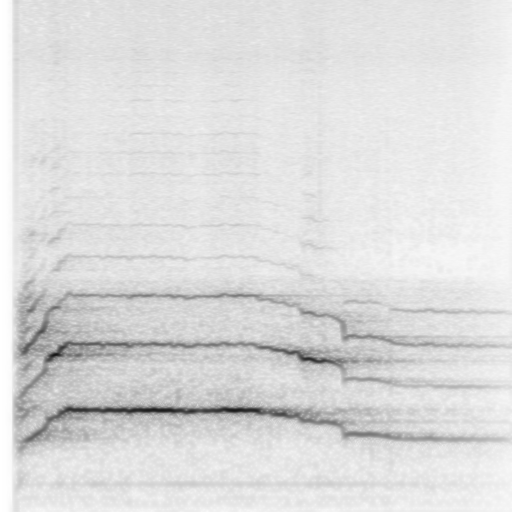

In [9]:
# take just first 5 seconds of audio
audio_cust_data = audio_cust_whole[:225500]

# Transfer audio to spectrogram image
spec_cust_data = spectrogram_from_waveform(audio_cust_data)

power_for_image = 0.25
max_volume = np.ceil(np.power(np.max(spec_cust_data),power_for_image)) # max volume depends on our audio recoding conditions
image_cust = image_from_spectrogram(spec_cust_data, max_volume=max_volume, power_for_image=power_for_image)
image_cust

In [10]:
waveform_initial = waveform_from_spectrogram(spectrogram_from_image(image_cust))
audio = Audio(waveform_initial, rate=sample_rate)
audio

## 8. Listen to the Reconstructed Audio
Convert the spectrogram back to a waveform so you can listen to the processed input before generation.



<Tip>

💡 `strength` is a value between 0.0 and 1.0 that controls the amount of noise added to the input image. Values that approach 1.0 allow for lots of variations but will also produce images that are not semantically consistent with the input.

</Tip>

Define the prompt and run the pipeline:

## Mask creator module
- Enter image parameters and adjust mask as required
- Brightness and Contrast has been adjusted to a default value of 0.05 and 200 respectively
- Adjust the downshift value to control creativity in music
- Feel free to change it as required


## 9. Interactive Mask Creator
Use the widgets below to adjust inversion, brightness, contrast, and downshift parameters. These control how the mask influences the generated music.

In [11]:
# @title Code
existing_images = {
    'None': None,
    'Generated Image': image_cust  # Example placeholder image
}

# Define image transformation functions
def invert_image(image_cust: Image.Image, factor: float = 1.0) -> Image.Image:
    image = image_cust.convert("L")
    inverted_image = ImageChops.invert(image)
    half_inverted_image = Image.blend(image, inverted_image, factor)
    return half_inverted_image

def bright_image(image: Image.Image, factor: float = 1.0) -> Image.Image:
    enhancer = ImageEnhance.Brightness(image)
    brightened_image = enhancer.enhance(factor)
    return brightened_image

def contrast_image(imagee: Image.Image, factor: float = 1.0) -> Image.Image:
    enhancer = ImageEnhance.Contrast(imagee)
    contrast_image = enhancer.enhance(factor)
    return contrast_image

def downshift_image(image: Image.Image, downshift_value: int = 150) -> Image.Image:
    image = image.convert("L")
    image_data = np.array(image)
    downshifted_data = np.where(image_data > downshift_value, image_data - downshift_value, 0).astype(np.uint8)
    downshifted_image = Image.fromarray(downshifted_data)
    return downshifted_image

# Master function to apply transformations based on user inputs, showing each step side by side
def mask_creator(image, invert_factor=1.0, bright_factor=1.0, contrast_factor=1.0, downshift_value=150):
    images = []  # List to hold each step's output image
    images.append((image, "Original Image"))
    # Step 1: Inversion
    if invert_factor >= 0:
        image = invert_image(image, invert_factor)
        images.append((image, "After Inversion"))

    # Step 2: Brightness Adjustment
    if bright_factor >= 0:
        image = bright_image(image, bright_factor)
        images.append((image, "After Brightness Adjustment"))

    # Step 3: Contrast Adjustment
    if contrast_factor >= 0:
        image = contrast_image(image, contrast_factor)
        images.append((image, "After Contrast Adjustment"))

    # Step 4: Downshift
    if downshift_value >= 0:
        image = downshift_image(image, downshift_value)
        images.append((image, "After Downshift"))

    return images, image  # Return both the intermediate steps and the final image

# Widgets for selecting image input method
image_variable_dropdown = widgets.Dropdown(
    options=list(existing_images.keys()),
    value='None',
    description='Select Image Var:',
    style={'description_width': 'initial'}
)

image_path_widget = widgets.Text(
    value='',
    description='Or Enter Path:',
    style={'description_width': 'initial'}
)

invert_factor_widget = widgets.FloatSlider(
    value=1.0,
    min=0.0,
    max=1.0,
    step=0.1,
    description='Invert Factor:',
)

bright_factor_widget = widgets.FloatText(
    value=0.05,
    description='Brightness Factor:',
    style={'description_width': 'initial'},
)
bright_hint = widgets.HTML("<small>Recommended: 0.5 to 2.0</small>")

contrast_factor_widget = widgets.FloatText(
    value=200.0,
    description='Contrast Factor:',
    style={'description_width': 'initial'},
)
contrast_hint = widgets.HTML("<small>Recommended: 0.5 to 2.0</small>")

downshift_value_widget = widgets.IntSlider(
    value=150,
    min=0,
    max=255,
    step=1,
    description='Downshift Value:',
)

output_image_widget = widgets.Output()

final_image_variable = None  # Variable to store the final output image

def on_button_click(b):
    global final_image_variable  # Use the global variable to store final image
    with output_image_widget:
        output_image_widget.clear_output()

        # Determine image source (existing variable or path)
        image = existing_images[image_variable_dropdown.value]
        if image is None and image_path_widget.value:
            image = Image.open(image_path_widget.value)

        if not image:
            print("Please select an image variable or provide a valid image path.")
            return

        # Apply mask_creator with the current widget values
        transformation_steps, final_image_variable = mask_creator(
            image,
            invert_factor_widget.value,
            bright_factor_widget.value,
            contrast_factor_widget.value,
            downshift_value_widget.value
        )

        # Display images side by side
        images_to_display = []
        for img, label in transformation_steps:
            img_out = widgets.Output()
            with img_out:
                print(label)
                display(img)
            images_to_display.append(img_out)

        display(widgets.HBox(images_to_display))

        # Inform the user that the image has been stored
        print("The final image has been stored in `final_image_variable`.")

# Button to trigger the mask_creator function
button = widgets.Button(description="Apply Transformations")
button.on_click(on_button_click)

# Display widgets and output
display(
    image_variable_dropdown,
    image_path_widget,
    invert_factor_widget,
    bright_factor_widget, bright_hint,
    contrast_factor_widget, contrast_hint,
    downshift_value_widget,
    button,
    output_image_widget
)

Dropdown(description='Select Image Var:', options=('None', 'Generated Image'), style=DescriptionStyle(descript…

Text(value='', description='Or Enter Path:', style=DescriptionStyle(description_width='initial'))

FloatSlider(value=1.0, description='Invert Factor:', max=1.0)

FloatText(value=0.05, description='Brightness Factor:', style=DescriptionStyle(description_width='initial'))

HTML(value='<small>Recommended: 0.5 to 2.0</small>')

FloatText(value=200.0, description='Contrast Factor:', style=DescriptionStyle(description_width='initial'))

HTML(value='<small>Recommended: 0.5 to 2.0</small>')

IntSlider(value=150, description='Downshift Value:', max=255)

Button(description='Apply Transformations', style=ButtonStyle())

Output()

In [12]:
# mape = Image.open("map.jpg")
#black_image = Image.new("RGB", (512, 512), (0,0,0))
# maper = preprocess_map(mape)
#black_imager = preprocess_map(black_image)
# mape
# half_inverted_image = invert_image(image_cust)
# half_inverted_imager = preprocess_map(half_inverted_image)

# darkened_image = bright_image(image_cust)
# darkened_imager = preprocess_map(darkened_image)

# contrast_image = contrast_image(image_cust)
# contrast_imager = preprocess_map(contrast_image)

# downshifted_image = downshift_image(image_cust)
# downshifted_imager = preprocess_map(downshifted_image)

final_map = preprocess_map(final_image_variable)


## 10. Prepare the Final Mask
After adjusting parameters, the final mask is created and preprocessed for use in the diffusion pipeline.

### 🎵 You can customize the prompt to include any genre or instrument of your choice.

## 11. Generate Music with Custom Prompt
Set your desired genre, instrument, or style in the prompt. The pipeline will use your mask and prompt to generate new music from the input sound.

  0%|          | 0/40 [00:00<?, ?it/s]

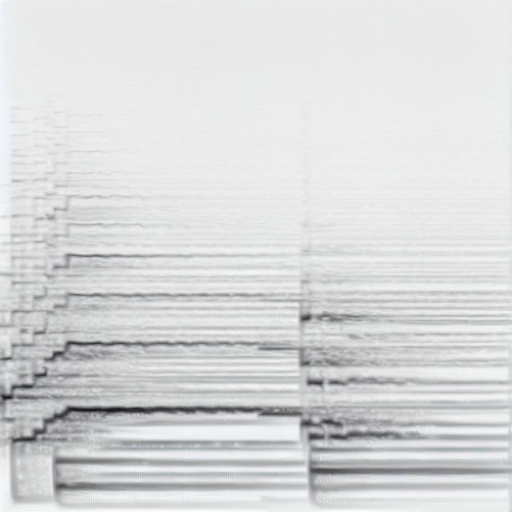

In [13]:
prompt = "instrumental , saxophone , flute"
generator = torch.Generator(device=device).manual_seed(1040)
image = pipe(prompt=prompt, image=image_cust, strength=0.8, guidance_scale=8, map=final_map, generator=generator).images[0]

image

### Convert the Mel-spectrogram back to an audio


## 12. Listen to the Generated Music
The final step converts the generated spectrogram back to audio so you can listen to your new music!

In [14]:
waveform_initial = waveform_from_spectrogram(spectrogram_from_image(image))
audio = Audio(waveform_initial, rate=sample_rate)
audio